In [36]:
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt

import joblib
import pickle

import optuna

from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, RocCurveDisplay, roc_auc_score, roc_curve

In [37]:
import sys

sys.path.append('../utils')

In [38]:
from predict import predict_class

In [39]:
TOKENIZER_PATH = '../learned_models'

X_TRAIN_PATH = '../data/x_train.json'
Y_TRAIN_PATH = '../data/y_train.json'

X_TEST_PATH = '../data/x_test.json'
Y_TEST_PATH = '../data/y_test.json'

In [40]:
with open(f'{TOKENIZER_PATH}/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [41]:
x_train = pd.read_json(X_TRAIN_PATH).values
y_train = pd.read_json(Y_TRAIN_PATH)

x_test = pd.read_json(X_TEST_PATH).values
y_test = pd.read_json(Y_TEST_PATH)

In [42]:
MODELS = ['rfc', 'catboost', 'logistic_regression'] # Список доступных моделей

USED_MODEL = 'logistic_regression'                                  # Выбранная модель

IS_RUN_OPTUNA = False                               # Запускать Optuna

NUM_WORDS = 5_000                                   # Максимальное количество слов
MAX_NEWS_LEN = 100                                  # Максимальная длина новости
NB_CLASSES = y_train.keys().shape[0]                # Количество классов

In [43]:
y_train_initial = y_train

y_train = y_train.values.argmax(axis=1)
y_test = y_test.values.argmax(axis=1)

In [44]:
def objective(trial):
    match USED_MODEL:
        case 'rfc':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                'max_depth': trial.suggest_int('max_depth', 2, 50),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
            }

            model = RandomForestClassifier(**params, random_state=42)
        case 'catboost':
            params = {
                'iterations': trial.suggest_int('iterations', 100, 400, step=100),
                'depth': trial.suggest_int('depth', 4, 7),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
                'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
                'border_count': trial.suggest_int('border_count', 32, 130),
                'verbose': False,
                'loss_function':'MultiClass'
            }

            model = CatBoostClassifier(**params, random_seed=42)
        case 'logistic_regression':
            params = {
                'multi_class': 'multinomial',
                'solver':'lbfgs',
                'penalty': trial.suggest_categorical('penalty', ['l2']),
                'C': trial.suggest_loguniform('C', 0.01, 10.0)
            }

            model = LogisticRegression(**params, random_state=42)
        case _:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                'max_depth': trial.suggest_int('max_depth', 2, 50),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
            }

            model = RandomForestClassifier(**params, random_state=42)
    
    # if USED_MODEL in ['catboost', 'logistic_regression']:
    #     model.fit(x_train, y_train.values.argmax(axis=1))
    # else:       
    #     model.fit(x_train, y_train)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return accuracy_score(y_test, y_pred)

In [45]:
if IS_RUN_OPTUNA:
    study = optuna.create_study(direction='maximize')
    
    study.optimize(objective, n_trials=50)

In [46]:
if IS_RUN_OPTUNA:
    best_params = study.best_params
     
    print(best_params)

In [47]:
match USED_MODEL:
    case 'rfc':
        # best_params = {
        #  'n_estimators': 200,
        #  'max_depth': 23,
        #  'min_samples_split': 19,
        #  'min_samples_leaf': 6
        # }

        best_params = {
            'n_estimators': 500, 
            'max_depth': 15, 
            'min_samples_leaf': 22,
            'min_samples_split': 27,
            'criterion': 'gini'
        }           
        
        model = RandomForestClassifier(**best_params, random_state=42, verbose=2)
    case 'catboost':
        best_params = {
            'iterations': 400, 
            'depth': 6, 
            'learning_rate': 0.21500609398476206, 
            'l2_leaf_reg': 5.104788890534899, 
            'border_count': 74
        }
        
        model = CatBoostClassifier(**best_params, random_seed=42)
    case 'logistic_regression':
        best_params = {'penalty': 'l2', 'C': 0.10704555665735006}
        
        model = LogisticRegression(**best_params, random_state=42)
    case _:
        best_params = {
            'n_estimators': 500, 
            'max_depth': 15, 
            'min_samples_leaf': 22,
            'min_samples_split': 27,
            'criterion': 'gini'
        }
        
        USED_MODEL = 'rfc'
        
        model = RandomForestClassifier(**best_params, random_state=42, verbose=2)

In [48]:
# if USED_MODEL in ['catboost', 'logistic_regression']:
#     model.fit(x_train, y_train.values.argmax(axis=1))
# else:           
#     model.fit(x_train, y_train)
    
model.fit(x_train, y_train)    

/opt/anaconda3/envs/python-3-10-14-base-backend-ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.10704555665735006, random_state=42)

In [49]:
y_pred_train = model.predict(x_train)

train_acc = accuracy_score(y_train, y_pred_train)

train_acc

0.6995614035087719

In [50]:
print("Classification Report:")
print(classification_report(y_train, y_pred_train))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1064
           1       0.62      0.59      0.60      1064
           2       0.65      0.60      0.62      1064

    accuracy                           0.70      3192
   macro avg       0.69      0.70      0.69      3192
weighted avg       0.69      0.70      0.69      3192



In [51]:
y_pred_test = model.predict(x_test)

train_acc = accuracy_score(y_test, y_pred_test)

train_acc

0.6650485436893204

In [52]:
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       287
           1       0.46      0.47      0.47       158
           2       0.55      0.50      0.53       173

    accuracy                           0.67       618
   macro avg       0.62      0.62      0.62       618
weighted avg       0.66      0.67      0.66       618



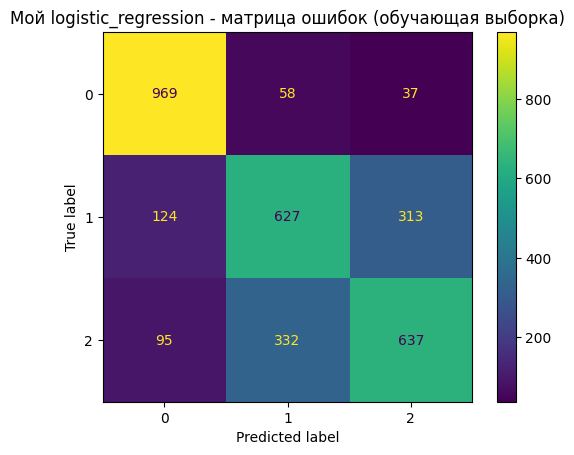

In [53]:
conf_matrix = confusion_matrix(y_train, y_pred_train)
conf_matrix_plot = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_plot.plot()

plt.title(f'Мой {USED_MODEL} - матрица ошибок (обучающая выборка)')
plt.show()

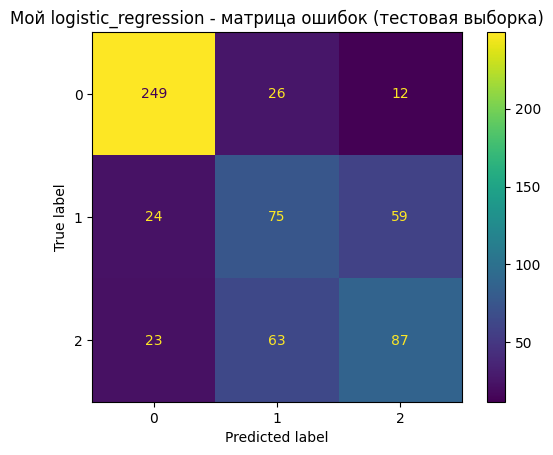

In [54]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix_plot = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_plot.plot()

plt.title(f'Мой {USED_MODEL} - матрица ошибок (тестовая выборка)')
plt.show()

In [55]:
text = 'В Ялте гаишникам пришлось гнаться за пьяным водителем и стрелять по колёсам, чтобы его остановить На патрулировании в ночи полицейские заметили авто с выключенными фарами. Водитель не остановился по требованию, началась погоня. После опасных заносов и виляний правоохранители приняли решение стрелять: один в воздух и семь — по колёсам. Только тогда тачка остановилась.'

predict_class(model, tokenizer, text, y_train_initial, MAX_NEWS_LEN)

'АВТО БАТЯ'

In [56]:
text = 'Ещё один радостный повод в первые дни лета 😎 Хаб Группы в Красноярске отметил 3 года! 🥳 ✈Сейчас из Международного аэропорта Красноярск им. Д.А. Хворостовского (https://t.me/kja_inform) мы выполняем полёты по 32 направлениям с учётом Москвы. 📍В летнем расписании еженедельно осуществляем до 42 рейсов в столицу, до 14 рейсов в Санкт-Петербург, Иркутск, Новосибирск, до 13 рейсов в Сочи, до 10 рейсов в Благовещенск. 🌍Широкая сеть маршрутов из сердца Сибири включает зарубежные пункты: Алматы, Бангкок, Бишкек, Пхукет, Харбин, Астана, Ош, Пекин, Санья, Ташкент.'

predict_class(model, tokenizer, text, y_train_initial, MAX_NEWS_LEN)

'АВТО БАТЯ'

In [57]:
text = 'Интегрировали станцию Кутузовская МЦД-4 с метро и МЦК  Первыми по новому крытому пешеходному мосту прошли мэр Москвы Сергей Собянин, глава РЖД Олег Белозёров и глава Сбербанка России Герман Греф. Переход сделали в едином стиле со станцией Кутузовская, чтобы он гармонично сочетался и с железнодорожной инфраструктурой, и с окружающей застройкой.'

predict_class(model, tokenizer, text, y_train_initial, MAX_NEWS_LEN)

'АВТО БАТЯ'

In [58]:
# SAVE_MODEL_PATH = '../learned_models'

# joblib.dump(model, f'{SAVE_MODEL_PATH}/model_{USED_MODEL}.pkl')